<a href="https://colab.research.google.com/github/dyou-wbg/meta_processing/blob/main/0513_final_shortTitle_SS_econOnly_3typesOfDistanceMetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from google.colab import drive
import csv
import os
import re
import pandas as pd
import numpy as np

directory = '/content/drive/MyDrive/finalMetaFile'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# from here

In [6]:

df= pd.read_csv(os.path.join(directory, 'combined_metadata_final12_econOnlySemanticScholar.csv'))

In [40]:
df.head()

,sourcename,title,word_count
5,jstor,the moscow-peking-washington triangle,3
9,jstor,the one germany,3
11,jstor,guaranteed jobs for human rights,5
48,jstor,optimum trade policies and retaliation,5
49,jstor,the limits of prevention,4


In [41]:
df['sourcename'].value_counts()


sourcename
semantic_scholar    318508
jstor               203504
repec                91591
scopus               83338
elsevier             17868
ssrn                  8974
econlit                952
3ie                     70
Name: count, dtype: int64

In [7]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize

df['title'] = df['title'].str.lower()

def remove_non_english(df):
  def is_english(text):
    words = word_tokenize(text)
    english_word_count = sum(len(word) >= 2 for word in words)
    return english_word_count / len(words) >= 0.9

  df_filtered = df[df['title'].apply(is_english)]
  return df_filtered

df['title'] = df['title'].astype(str)
df = df[~df['title'].str.contains('و|д|я|š|ü|à|é|ś|ä|ú|의|θ|λ|ό|τ|η|τ|α|の|と', regex=True)]
df = remove_non_english(df.copy())
def count_words(title):
  words = title.split()
  return len(words)

df['word_count'] = df['title'].apply(count_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
min=1
max=5

df = df[(df['word_count'] >= min) & (df['word_count'] <= max)]



def sample_dataframe(df, sample_size):
  if len(df) > sample_size:
    return df.sample(n=sample_size, random_state=321)
  else:
    return df




In [42]:
# make df_title1 with random sample of df
title_sample_size= 6000
df_title1 = sample_dataframe(df, title_sample_size)
df_title1 = df_title1.rename(columns={"title": "title1","sourcename": "sourcename1","word_count": "word_count1"})


In [43]:
df_title1['sourcename1'].nunique()


7

In [44]:
df_title1['sourcename1'].unique()


array(['scopus', 'jstor', 'semantic_scholar', 'repec', 'elsevier', 'ssrn',
       'econlit'], dtype=object)

In [45]:
# make df_title2

#df_title2 = df[~df['title'].isin(df_title1['title1'])]
df_title2 = df.drop(df_title1.index)

In [46]:
df_title2 = df_title2.rename(columns={"title": "title2","sourcename": "sourcename2","word_count": "word_count2"})
df_title2.head()

,sourcename2,title2,word_count2
5,jstor,the moscow-peking-washington triangle,3
9,jstor,the one germany,3
11,jstor,guaranteed jobs for human rights,5
48,jstor,optimum trade policies and retaliation,5
49,jstor,the limits of prevention,4


# apply two condition to build a pooled df

In [47]:
df_title1 = df_title1.reset_index(drop=True)
df_title2 = df_title2.reset_index(drop=True)
len(df_title1),len(df_title2)

(6000, 718805)

In [48]:
df_pair=pd.concat([df_title1, df_title2], axis=1)
len(df_pair)

718805

In [49]:
df_pair = df_pair.drop(df_pair.loc[df_pair['sourcename1'] == df_pair['sourcename2']].index)
len(df_pair)

717128

In [50]:
df_pair = df_pair.drop(df_pair.loc[(df_pair['word_count2'] > df_pair['word_count1']+3) | (df_pair['word_count2'] < df_pair['word_count1']-3)].index)
len(df_pair)

716892

In [51]:
df_pair = df_pair.dropna(subset=['sourcename1'])
df_pair.head()

,sourcename1,title1,word_count1,sourcename2,title2,word_count2
0,scopus,globalization drives strategic product switching,5.0,jstor,the moscow-peking-washington triangle,3
2,semantic_scholar,the european banking disunion,4.0,jstor,guaranteed jobs for human rights,5
3,repec,the key-country approach,3.0,jstor,optimum trade policies and retaliation,5
4,semantic_scholar,ökonomische grundlagen des haftungsrechts,4.0,jstor,the limits of prevention,4
5,scopus,building brands in china,4.0,jstor,constitutional law in 1950-1951,4


In [35]:
df_pair=pd.read_csv(os.path.join(directory, '0513_df_pair_2k_shortTitles.csv'))

In [52]:
 df_pair['sourcename1'].unique()


array(['scopus', 'semantic_scholar', 'repec', 'elsevier', 'ssrn',
       'econlit'], dtype=object)

In [53]:
df_pair.head()

,sourcename1,title1,word_count1,sourcename2,title2,word_count2
0,scopus,globalization drives strategic product switching,5.0,jstor,the moscow-peking-washington triangle,3
2,semantic_scholar,the european banking disunion,4.0,jstor,guaranteed jobs for human rights,5
3,repec,the key-country approach,3.0,jstor,optimum trade policies and retaliation,5
4,semantic_scholar,ökonomische grundlagen des haftungsrechts,4.0,jstor,the limits of prevention,4
5,scopus,building brands in china,4.0,jstor,constitutional law in 1950-1951,4


# compute distance

In [54]:
from string import printable
from collections import Counter

printable_dict = {c:i for i,c in enumerate(printable)}

def vectorize(title):
    cnt = Counter(title)
    array = [0 for _ in printable]+[0]
    for c,n in cnt.items():
        if c in printable_dict:
            array[printable_dict[c]]=n
        else:
            array[-1]+=n
    return np.array(array)

vects = []
for title in df_pair.title1:
    vects.append(vectorize(title))

In [55]:
df_pair['vects1']=vects

In [56]:
vects_2 = []
for title in df_pair.title2:
    vects_2.append(vectorize(title))

In [57]:
df_pair['vects2']=vects_2
df_pair.head()

,sourcename1,title1,word_count1,sourcename2,title2,word_count2,vects1,vects2
0,scopus,globalization drives strategic product switching,5.0,jstor,the moscow-peking-washington triangle,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 3, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 3, ..."
2,semantic_scholar,the european banking disunion,4.0,jstor,guaranteed jobs for human rights,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 1, 2, ..."
3,repec,the key-country approach,3.0,jstor,optimum trade policies and retaliation,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 2, 3, ..."
4,semantic_scholar,ökonomische grundlagen des haftungsrechts,4.0,jstor,the limits of prevention,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, ..."
5,scopus,building brands in china,4.0,jstor,constitutional law in 1950-1951,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0, ...","[1, 3, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 1, 0, 0, ..."


In [58]:
def l1_distance(v1, v2):
  # Ensure both arrays have the same size
  if len(v1) != len(v2):
    raise ValueError("Input vectors must have the same size")
  # Calculate absolute difference between corresponding elements
  diff = np.abs(np.array(v1) - np.array(v2))
  # Return the sum of absolute differences (L1 norm)
  return np.sum(diff)

# Apply the function to each pair of vectors in the columns
df_pair['L1_distance'] = df_pair.apply(lambda row: l1_distance(row['vects1'], row['vects2']), axis=1)
df_pair.head()

,sourcename1,title1,word_count1,sourcename2,title2,word_count2,vects1,vects2,L1_distance
0,scopus,globalization drives strategic product switching,5.0,jstor,the moscow-peking-washington triangle,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 3, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 3, ...",29
2,semantic_scholar,the european banking disunion,4.0,jstor,guaranteed jobs for human rights,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 1, 2, ...",19
3,repec,the key-country approach,3.0,jstor,optimum trade policies and retaliation,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 2, 3, ...",28
4,semantic_scholar,ökonomische grundlagen des haftungsrechts,4.0,jstor,the limits of prevention,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, ...",27
5,scopus,building brands in china,4.0,jstor,constitutional law in 1950-1951,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0, ...","[1, 3, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 1, 0, 0, ...",25


In [59]:
df_pair['annotation_label'] = df_pair.apply(lambda row: 1 if row['title1'] == row['title2'] else 0, axis=1)

In [60]:

df_pair[df_pair['annotation_label'] == 1]


,sourcename1,title1,word_count1,sourcename2,title2,word_count2,vects1,vects2,L1_distance,annotation_label


In [61]:
from scipy.spatial.distance import cosine

def cosine_similarity(v1, v2):
  if len(v1) != len(v2):
    raise ValueError("Input vectors must have the same size")
  return 1 - cosine(v1, v2)

df_pair['Cosine_Similarity'] = df_pair.apply(lambda row: cosine_similarity(row['vects1'], row['vects2']), axis=1)


In [62]:
df_pair.head()

,sourcename1,title1,word_count1,sourcename2,title2,word_count2,vects1,vects2,L1_distance,annotation_label,Cosine_Similarity
0,scopus,globalization drives strategic product switching,5.0,jstor,the moscow-peking-washington triangle,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 3, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 3, ...",29,0,0.827837
2,semantic_scholar,the european banking disunion,4.0,jstor,guaranteed jobs for human rights,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 1, 2, ...",19,0,0.800019
3,repec,the key-country approach,3.0,jstor,optimum trade policies and retaliation,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 2, 3, ...",28,0,0.680031
4,semantic_scholar,ökonomische grundlagen des haftungsrechts,4.0,jstor,the limits of prevention,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, ...",27,0,0.717264
5,scopus,building brands in china,4.0,jstor,constitutional law in 1950-1951,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0, ...","[1, 3, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 1, 0, 0, ...",25,0,0.643494


In [63]:
df_pair.to_csv(os.path.join(directory, '0513_df_pair_2k_shortTitles_distance.csv'), index=False)

# sentence BERT


In [64]:
!pip install sentence-transformers

In [65]:
from sentence_transformers import SentenceTransformer, util
# Load the pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [66]:
titles1 = df_pair['title1'].tolist()
titles2 = df_pair['title2'].tolist()

# Encode the titles into sentence embeddings
embeddings1 = model.encode(titles1, convert_to_tensor=True)
embeddings2 = model.encode(titles2, convert_to_tensor=True)

# Compute cosine similarity between embeddings
cosine_scores = util.cos_sim(embeddings1, embeddings2)

# Save results to a CSV file
results = pd.DataFrame({'title1': titles1,
                        'title2': titles2,
                        'similarity_score': cosine_scores.diagonal()})

In [67]:
# Save results to a CSV file
results = pd.DataFrame({'title1': titles1,
                        'title2': titles2,
                        'similarity_score': cosine_scores.diagonal()})

In [68]:
results.head()

,title1,title2,similarity_score
0,globalization drives strategic product switching,the moscow-peking-washington triangle,0.084462
1,the european banking disunion,guaranteed jobs for human rights,0.081198
2,the key-country approach,optimum trade policies and retaliation,0.317444
3,ökonomische grundlagen des haftungsrechts,the limits of prevention,0.116397
4,building brands in china,constitutional law in 1950-1951,-0.039159


In [69]:
df_temp=df_pair.copy()

In [70]:
df_pair = df_pair.join(results, how='left', rsuffix='_r')
df_pair.head()

,sourcename1,title1,word_count1,sourcename2,title2,word_count2,vects1,vects2,L1_distance,annotation_label,Cosine_Similarity,title1_r,title2_r,similarity_score
0,scopus,globalization drives strategic product switching,5.0,jstor,the moscow-peking-washington triangle,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 3, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 3, ...",29,0,0.827837,globalization drives strategic product switching,the moscow-peking-washington triangle,0.084462
2,semantic_scholar,the european banking disunion,4.0,jstor,guaranteed jobs for human rights,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 1, 2, ...",19,0,0.800019,the key-country approach,optimum trade policies and retaliation,0.317444
3,repec,the key-country approach,3.0,jstor,optimum trade policies and retaliation,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 2, 3, ...",28,0,0.680031,ökonomische grundlagen des haftungsrechts,the limits of prevention,0.116397
4,semantic_scholar,ökonomische grundlagen des haftungsrechts,4.0,jstor,the limits of prevention,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, ...",27,0,0.717264,building brands in china,constitutional law in 1950-1951,-0.039159
5,scopus,building brands in china,4.0,jstor,constitutional law in 1950-1951,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0, ...","[1, 3, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 1, 0, 0, ...",25,0,0.643494,within oecd countries,theoretical notes on trade problems,0.253639


In [71]:

df_pair = df_pair.drop(columns=['title2_r'])

In [72]:
df_pair = df_pair.drop(columns=['vects1','vects2'])


In [76]:
df_pair.head()

,index,sourcename1,title1,word_count1,sourcename2,title2,word_count2,L1_distance,annotation_label,Cosine_Similarity,similarity_score
0,0,scopus,globalization drives strategic product switching,5.0,jstor,the moscow-peking-washington triangle,3,29,0,0.827837,0.084462
1,2,semantic_scholar,the european banking disunion,4.0,jstor,guaranteed jobs for human rights,5,19,0,0.800019,0.317444
2,3,repec,the key-country approach,3.0,jstor,optimum trade policies and retaliation,5,28,0,0.680031,0.116397
3,4,semantic_scholar,ökonomische grundlagen des haftungsrechts,4.0,jstor,the limits of prevention,4,27,0,0.717264,-0.039159
4,5,scopus,building brands in china,4.0,jstor,constitutional law in 1950-1951,4,25,0,0.643494,0.253639


In [77]:
df_pair = df_pair.drop(columns=['index'])

In [78]:
df_pair.head()

,sourcename1,title1,word_count1,sourcename2,title2,word_count2,L1_distance,annotation_label,Cosine_Similarity,similarity_score
0,scopus,globalization drives strategic product switching,5.0,jstor,the moscow-peking-washington triangle,3,29,0,0.827837,0.084462
1,semantic_scholar,the european banking disunion,4.0,jstor,guaranteed jobs for human rights,5,19,0,0.800019,0.317444
2,repec,the key-country approach,3.0,jstor,optimum trade policies and retaliation,5,28,0,0.680031,0.116397
3,semantic_scholar,ökonomische grundlagen des haftungsrechts,4.0,jstor,the limits of prevention,4,27,0,0.717264,-0.039159
4,scopus,building brands in china,4.0,jstor,constitutional law in 1950-1951,4,25,0,0.643494,0.253639


In [79]:
cols = df_pair.columns.tolist()
cols

['sourcename1',
 'title1',
 'word_count1',
 'sourcename2',
 'title2',
 'word_count2',
 'L1_distance',
 'annotation_label',
 'Cosine_Similarity',
 'similarity_score']

In [80]:
df_final = df_pair[['title1', 'title2', 'sourcename1', 'sourcename2', 'word_count1','word_count2','annotation_label','L1_distance','Cosine_Similarity','similarity_score']]

In [81]:
df_final.head()

,title1,title2,sourcename1,sourcename2,word_count1,word_count2,annotation_label,L1_distance,Cosine_Similarity,similarity_score
0,globalization drives strategic product switching,the moscow-peking-washington triangle,scopus,jstor,5.0,3,0,29,0.827837,0.084462
1,the european banking disunion,guaranteed jobs for human rights,semantic_scholar,jstor,4.0,5,0,19,0.800019,0.317444
2,the key-country approach,optimum trade policies and retaliation,repec,jstor,3.0,5,0,28,0.680031,0.116397
3,ökonomische grundlagen des haftungsrechts,the limits of prevention,semantic_scholar,jstor,4.0,4,0,27,0.717264,-0.039159
4,building brands in china,constitutional law in 1950-1951,scopus,jstor,4.0,4,0,25,0.643494,0.253639


In [82]:
df_final['L1_distance_norm'] = (df_final['L1_distance'] - df_final['L1_distance'].min()) / (df_final['L1_distance'].max() - df_final['L1_distance'].min())
df_final['Cosine_Similarity_norm'] = (df_final['Cosine_Similarity'] - df_final['Cosine_Similarity'].min()) / (df_final['Cosine_Similarity'].max() - df_final['Cosine_Similarity'].min())
df_final['similarity_score_norm'] = (df_final['similarity_score'] - df_final['similarity_score'].min()) / (df_final['similarity_score'].max() - df_final['similarity_score'].min())

df_final.head()


<ipython-input-82-d13fb4b777a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['L1_distance_norm'] = (df_final['L1_distance'] - df_final['L1_distance'].min()) / (df_final['L1_distance'].max() - df_final['L1_distance'].min())
<ipython-input-82-d13fb4b777a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Cosine_Similarity_norm'] = (df_final['Cosine_Similarity'] - df_final['Cosine_Similarity'].min()) / (df_final['Cosine_Similarity'].max() - df_final['Cosine_Similarity'].min())
<ipython-i

,title1,title2,sourcename1,sourcename2,word_count1,word_count2,annotation_label,L1_distance,Cosine_Similarity,similarity_score,L1_distance_norm,Cosine_Similarity_norm,similarity_score_norm
0,globalization drives strategic product switching,the moscow-peking-washington triangle,scopus,jstor,5.0,3,0,29,0.827837,0.084462,0.2625,0.875139,0.339767
1,the european banking disunion,guaranteed jobs for human rights,semantic_scholar,jstor,4.0,5,0,19,0.800019,0.317444,0.1375,0.845731,0.622694
2,the key-country approach,optimum trade policies and retaliation,repec,jstor,3.0,5,0,28,0.680031,0.116397,0.2500,0.718887,0.378548
3,ökonomische grundlagen des haftungsrechts,the limits of prevention,semantic_scholar,jstor,4.0,4,0,27,0.717264,-0.039159,0.2375,0.758247,0.189645
4,building brands in china,constitutional law in 1950-1951,scopus,jstor,4.0,4,0,25,0.643494,0.253639,0.2125,0.680262,0.545212


In [83]:

df_final['Average_Score'] = (df_final['L1_distance_norm'] + df_final['Cosine_Similarity_norm'] + df_final['similarity_score_norm']) / 3
df_final.head()


<ipython-input-83-cb5900fc7212>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Average_Score'] = (df_final['L1_distance_norm'] + df_final['Cosine_Similarity_norm'] + df_final['similarity_score_norm']) / 3


,title1,title2,sourcename1,sourcename2,word_count1,word_count2,annotation_label,L1_distance,Cosine_Similarity,similarity_score,L1_distance_norm,Cosine_Similarity_norm,similarity_score_norm,Average_Score
0,globalization drives strategic product switching,the moscow-peking-washington triangle,scopus,jstor,5.0,3,0,29,0.827837,0.084462,0.2625,0.875139,0.339767,0.492469
1,the european banking disunion,guaranteed jobs for human rights,semantic_scholar,jstor,4.0,5,0,19,0.800019,0.317444,0.1375,0.845731,0.622694,0.535308
2,the key-country approach,optimum trade policies and retaliation,repec,jstor,3.0,5,0,28,0.680031,0.116397,0.2500,0.718887,0.378548,0.449145
3,ökonomische grundlagen des haftungsrechts,the limits of prevention,semantic_scholar,jstor,4.0,4,0,27,0.717264,-0.039159,0.2375,0.758247,0.189645,0.395131
4,building brands in china,constitutional law in 1950-1951,scopus,jstor,4.0,4,0,25,0.643494,0.253639,0.2125,0.680262,0.545212,0.479325


In [84]:

df_final = df_final.sort_values(by=['Average_Score'], ascending=False)
df_final.head()


,title1,title2,sourcename1,sourcename2,word_count1,word_count2,annotation_label,L1_distance,Cosine_Similarity,similarity_score,L1_distance_norm,Cosine_Similarity_norm,similarity_score_norm,Average_Score
1122,optimal incentives under gift exchange,economic development in historical perspective,econlit,jstor,5.0,5,0,22,0.896124,0.628144,0.1750,0.947327,1.000000,0.707442
1113,optimal growth under uncertainty,individual preferences and distributional adju...,elsevier,jstor,4.0,5,0,31,0.823108,0.536830,0.2875,0.870139,0.889111,0.682250
419,teoretyczne aspekty kosztowo-strukturalnych pr...,the socialist party,semantic_scholar,jstor,5.0,3,0,42,0.796262,0.320632,0.4250,0.841759,0.626566,0.631108
1691,alternative finance and sustainable development,nchs dataline,semantic_scholar,jstor,5.0,2,0,36,0.877463,0.297619,0.3500,0.927600,0.598619,0.625406
43,signaling and strategically delayed promotion,simulation approaches to locational conflicts,semantic_scholar,jstor,5.0,5,0,24,0.838137,0.453971,0.2000,0.886027,0.788490,0.624839


In [85]:
df_final.to_csv(os.path.join(directory, '0513_df_pair_2k_shortTitles_distance_norm_harmony.csv'), index=False)

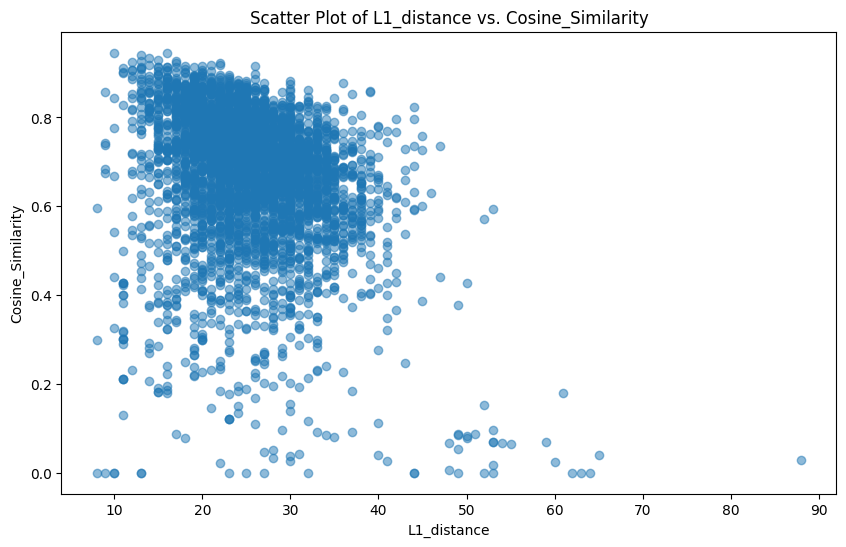

In [89]:

import matplotlib.pyplot as plt

# Extract the desired columns from the DataFrame
x = df_final['L1_distance']
y = df_final['Cosine_Similarity']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)

# Set labels and title
plt.xlabel('L1_distance')
plt.ylabel('Cosine_Similarity')
plt.title('Scatter Plot of L1_distance vs. Cosine_Similarity')

# Show the plot
plt.show()


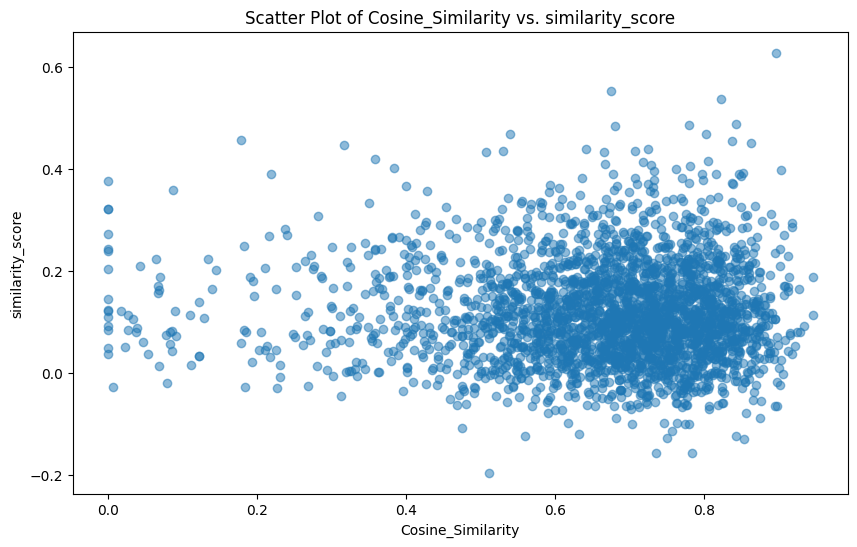

In [90]:

import matplotlib.pyplot as plt
# Extract the desired columns from the DataFrame
x = df_final['Cosine_Similarity']
y = df_final['similarity_score']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)

# Set labels and title
plt.xlabel('Cosine_Similarity')
plt.ylabel('similarity_score')
plt.title('Scatter Plot of Cosine_Similarity vs. similarity_score')

# Show the plot
plt.show()


In [ ]:
# low similarity score  indicates dissimilar titles.

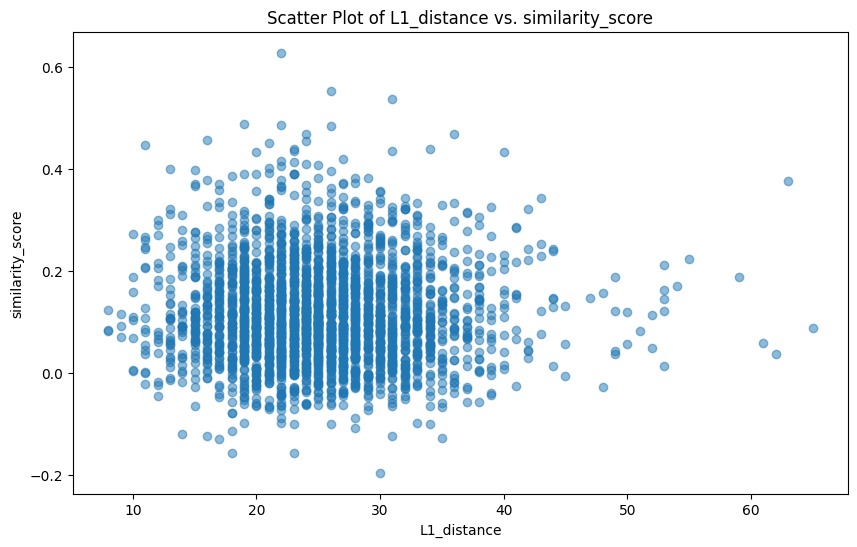

In [92]:

import matplotlib.pyplot as plt
# Extract the desired columns from the DataFrame
x = df_final['L1_distance']
y = df_final['similarity_score']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)

# Set labels and title
plt.xlabel('L1_distance')
plt.ylabel('similarity_score')
plt.title('Scatter Plot of L1_distance vs. similarity_score')

# Show the plot
plt.show()


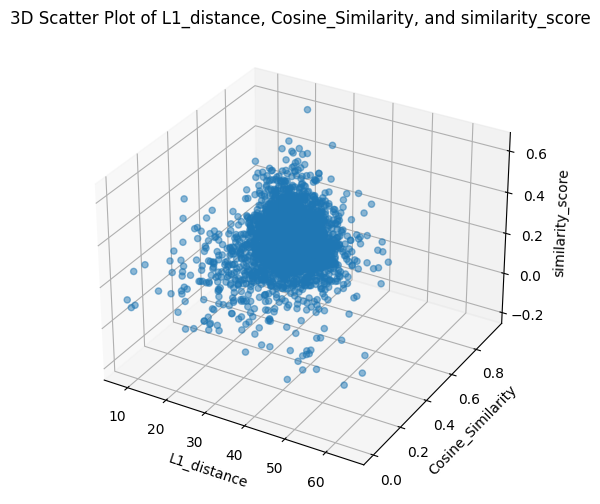

In [91]:

import matplotlib.pyplot as plt
# Extract the desired columns from the DataFrame
x = df_final['L1_distance']
y = df_final['Cosine_Similarity']
z = df_final['similarity_score']

# Create the 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, alpha=0.5)

# Set labels and title
ax.set_xlabel('L1_distance')
ax.set_ylabel('Cosine_Similarity')
ax.set_zlabel('similarity_score')
ax.set_title('3D Scatter Plot of L1_distance, Cosine_Similarity, and similarity_score')

# Show the plot
plt.show()


In [96]:
df_final.head(50)

,title1,title2,sourcename1,sourcename2,word_count1,word_count2,annotation_label,L1_distance,Cosine_Similarity,similarity_score,L1_distance_norm,Cosine_Similarity_norm,similarity_score_norm,Average_Score
1122,optimal incentives under gift exchange,economic development in historical perspective,econlit,jstor,5.0,5,0,22,0.896124,0.628144,0.1750,0.947327,1.000000,0.707442
1113,optimal growth under uncertainty,individual preferences and distributional adju...,elsevier,jstor,4.0,5,0,31,0.823108,0.536830,0.2875,0.870139,0.889111,0.682250
419,teoretyczne aspekty kosztowo-strukturalnych pr...,the socialist party,semantic_scholar,jstor,5.0,3,0,42,0.796262,0.320632,0.4250,0.841759,0.626566,0.631108
1691,alternative finance and sustainable development,nchs dataline,semantic_scholar,jstor,5.0,2,0,36,0.877463,0.297619,0.3500,0.927600,0.598619,0.625406
43,signaling and strategically delayed promotion,simulation approaches to locational conflicts,semantic_scholar,jstor,5.0,5,0,24,0.838137,0.453971,0.2000,0.886027,0.788490,0.624839
1042,advertising bans,rehabilitation of partial equilibrium theory,scopus,jstor,2.0,5,0,40,0.665809,0.432835,0.4000,0.703852,0.762823,0.622225
383,bonfire of the andes,factor-price uncertainty with variable proport...,semantic_scholar,jstor,4.0,5,0,34,0.725476,0.440033,0.3250,0.766929,0.771563,0.621164
339,financial intermediation and the economy,the confirmation clog,repec,jstor,5.0,3,0,21,0.863095,0.450281,0.1625,0.912411,0.784009,0.619640
1578,external economic relationships,stamp returns and economic factors,semantic_scholar,jstor,3.0,5,0,19,0.842701,0.487793,0.1375,0.890852,0.829562,0.619305
1443,macroeconomics income and monetary theory,the irrigation demand for electricity,semantic_scholar,jstor,5.0,5,0,24,0.802135,0.468712,0.2000,0.847967,0.806390,0.618119
